### Cats vs Dogs classification using a pretrained convnet(VGG16) with the method of feature extraction

Take the convolutional base of the VGG16 attach on top a new classifier and make predictions

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus=tf.config.list_physical_devices('GPU')

#configure the GPU(s), to use the memory necessary up to the GPU max memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
            print(tf.config.experimental.get_device_details(gpu))
        logi_gpu=tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus),'Physical GPU(s)',len(logi_gpu),'Logical GPU(s)')
        
    except RuntimeError as e:
        print(e)
print("Is gpu available?, :",tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))

Num GPUs Available:  1
{'device_name': 'NVIDIA GeForce RTX 2060', 'compute_capability': (7, 5)}
1 Physical GPU(s) 1 Logical GPU(s)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is gpu available?, : True


In [42]:
from keras.applications import VGG16
conv_base=VGG16(weights="imagenet",include_top=False,input_shape=(150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape (4,4,512) the densely connected classifier sticks 
on top of the layer
There are to option to train the new classifier

* 1 run all the training dataset on the conv_base, record the output and train
with this output the new classifier then stick it together, solution(fast and cheap)

* 2 extend the model(add layers to the conv_base) run the whole train dataset on the model(this allowed data augmetation )


#### Fast feature extraction without data augmentation

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
train_dir="CatsvsDogs_small_dataset\\Train"
val_dir="CatsvsDogs_small_dataset\\Validation"
test_dir="CatsvsDogs_small_dataset\\Test"
datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_feature(dir,sample_count):
    fea=np.zeros(shape=(sample_count,4,4,512))#features predicted by the conv base
    labels=np.zeros(shape=(sample_count))#labels of each feature
    generator=datagen.flow_from_directory(
        dir,target_size=(150,150),
        batch_size=batch_size,
        class_mode="binary")#dataset generator
        #loop fo
    i=0
    for i_b,l_b in generator:
        f_b=conv_base.predict(i_b)
        fea[i*batch_size:(i+1)*batch_size]=f_b
        labels[i*(batch_size):(i+1)*batch_size]=l_b
        i+=1
        if i*batch_size>=sample_count:
            break
    return fea,labels
train_f,train_l=extract_feature(train_dir,2000)
test_f,test_l=extract_feature(test_dir,1000)
val_f,val_l=extract_feature(val_dir,1000)
train_f=np.reshape(train_f,(2000,4*4*512))
test_f=np.reshape(test_f,(1000,4*4*512))
val_f=np.reshape(val_f,(1000,4*4*512))

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 25ms/step
Found 1001 images belonging to 2 classes.
1/1 [==============================] - 0s 22ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 26ms/step


In [9]:
###defining and training the densely connected classifier
from keras import models,layers,optimizers
model=models.Sequential()
model.add(layers.Dense(256,activation="relu",input_dim=(4*4*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation="sigmoid"))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss="binary_crossentropy",
              metrics=["acc"])
history=model.fit(train_f,train_l,
                  epochs=30,batch_size=batch_size,
                  validation_data=(val_f,val_l))

Epoch 1/30
100/100 [==============================] - 2s 10ms/step - loss: 0.5927 - acc: 0.6820 - val_loss: 0.4314 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3967 - acc: 0.8260 - val_loss: 0.3600 - val_acc: 0.8540
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3441 - acc: 0.8585 - val_loss: 0.3313 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3014 - acc: 0.8740 - val_loss: 0.3123 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2664 - acc: 0.8960 - val_loss: 0.2997 - val_acc: 0.8710
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2505 - acc: 0.9070 - val_loss: 0.2947 - val_acc: 0.8770
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2176 - acc: 0.9175 - val_loss: 0.2938 - val_acc: 0.8740
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0

32/32 [==============================] - 0s 6ms/step - loss: 0.2437 - acc: 0.8980
Test accuracy: 0.90


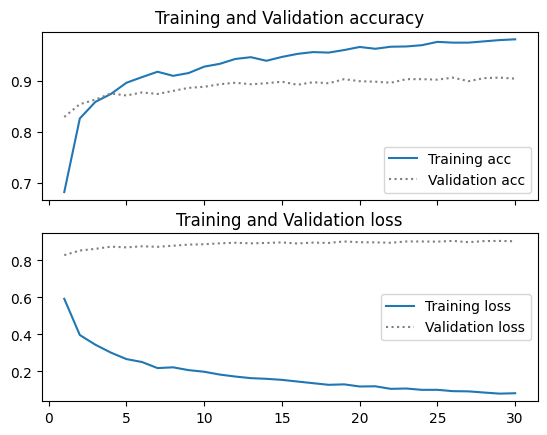

In [21]:
#ploting the results
import matplotlib.pyplot as plt
acc=history.history["acc"]
val_acc=history.history["val_acc"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(acc)+1)
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.plot(epochs,acc,label="Training acc")
ax1.plot(epochs,val_acc,ls=":",color="gray",label="Validation acc")
ax1.legend()
ax1.set_title("Training and Validation accuracy")

ax2.plot(epochs,loss,label="Training loss")
ax2.plot(epochs,val_acc,color="gray",ls=":",label="Validation loss")
ax2.legend()
ax2.set_title("Training and Validation loss")
test_loss,test_acc=model.evaluate(test_f,test_l)
print("Test accuracy: {:.2f}".format(test_acc))


1/1 [==============================] - 0s 21ms/step


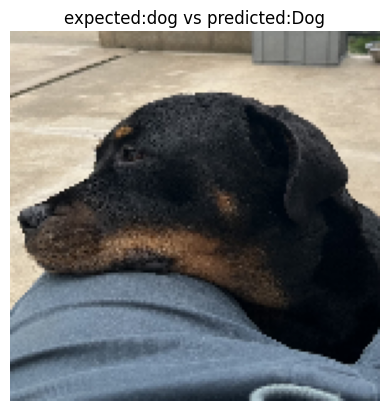

In [26]:
#testing model prediction with my dog's picture
import cv2
img_t=cv2.imread("mine.jpg",cv2.IMREAD_COLOR)
img_t=cv2.cvtColor(img_t,cv2.COLOR_BGR2RGB)
img_t=img=cv2.resize(img_t,(150,150))
def get_key(dic,item):
    item=int(item)
    for key,value in dic.items():
        if value==item:
            return key
    return None

dic={"Cat":0,"Dog":1}        

plt.imshow(img_t)
conv_base_pre=conv_base.predict(img_t.reshape((1,)+img_t.shape))
label_pre=model.predict(conv_base_pre.reshape(1,4*4*512))

plt.title("expected:dog vs predicted:{}".
          format(get_key(dic,label_pre[0][0])))
plt.axis("off")
plt.show()

#### Feature extraction with data augmentation

In [43]:
model2=models.Sequential()
model2.add(conv_base)#adding the pretrained conv base
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation="relu"))
model2.add(layers.Dense(1,activation="sigmoid"))
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [44]:
#Befor compile and train is important to freeze some layers, thoese which learnt the
#most generic features meaning the top botoom layers
#freezing the layers is achieved by setting it's atribuite trainable to false
print("This is the number of trainable weights"
      "before freezing the conv base:",len(model2.trainable_variables))
model2.layers[0].trainable=False
print("This is the number of trainable weight"
      "after freezing the conv base:",len(model2.trainable_weights))

This is the number of trainable weightsbefore freezing the conv base: 30
This is the number of trainable weightafter freezing the conv base: 4


In [53]:
#Training the model end to end with a frozen conv base
train_aug=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,
                             height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,
                             horizontal_flip=True,fill_mode="nearest")
                            #data augmentation technique

train_g_aug=train_aug.flow_from_directory("CatsvsDogs_small_dataset\Train",
                                        target_size=(150,150),
                                        batch_size=20,
                                        class_mode="binary")
                                        #creating the generator

val_d=ImageDataGenerator(rescale=1./255)
val_g=val_d.flow_from_directory("CatsvsDogs_small_dataset\Validation",
                                target_size=(150,150),batch_size=20,
                                class_mode="binary")
                                    
test_d=ImageDataGenerator(rescale=1./255)
test_g=test_d.flow_from_directory("CatsvsDogs_small_dataset\Test",
                                target_size=(150,150),batch_size=20,
                                class_mode="binary")
model2.compile(loss="binary_crossentropy",
               optimizer=optimizers.RMSprop(lr=2e-5),
               metrics=["acc"])
history_model2=model2.fit(train_g_aug,
                          epochs=30,
                          steps_per_epoch=100,
                          validation_data=val_g,
                          validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 14s 129ms/step - loss: 0.2383 - acc: 0.8940 - val_loss: 0.2534 - val_acc: 0.9080
Epoch 2/30
100/100 [==============================] - 14s 142ms/step - loss: 0.2404 - acc: 0.9030 - val_loss: 0.2511 - val_acc: 0.9090
Epoch 3/30
100/100 [==============================] - 15s 147ms/step - loss: 0.2274 - acc: 0.9100 - val_loss: 0.2565 - val_acc: 0.9080
Epoch 4/30
100/100 [==============================] - 13s 134ms/step - loss: 0.2345 - acc: 0.9030 - val_loss: 0.2481 - val_acc: 0.9080
Epoch 5/30
100/100 [==============================] - 15s 155ms/step - loss: 0.2335 - acc: 0.9055 - val_loss: 0.2366 - val_acc: 0.9100
Epoch 6/30
100/100 [==============================] - 15s 154ms/step - loss: 0.2402 - acc: 0.9010 - val_loss: 0.2619 - val_acc: 0.9030
Epoch 7/30
100/100 [==============================] - 15s 154ms/

51/51 [==============================] - 3s 50ms/step - loss: 0.2622 - acc: 0.8981
Test accuracy: 0.90


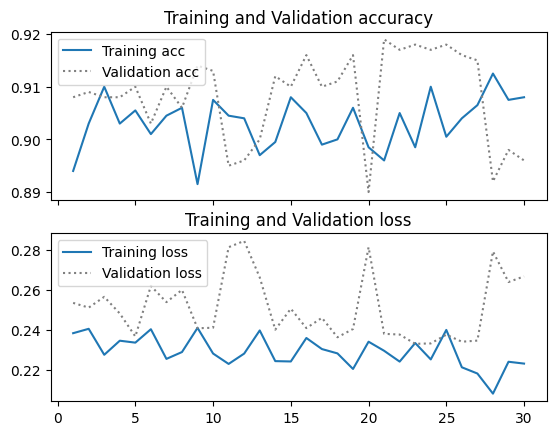

In [56]:
#ploting the results
import matplotlib.pyplot as plt
acc_model2=history_model2.history["acc"]
val_acc_model2=history_model2.history["val_acc"]
loss_model2=history_model2.history["loss"]
val_loss_model2=history_model2.history["val_loss"]
epochs=range(1,len(acc_model2)+1)
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.plot(epochs,acc_model2,label="Training acc")
ax1.plot(epochs,val_acc_model2,ls=":",color="gray",label="Validation acc")
ax1.legend()
ax1.set_title("Training and Validation accuracy")

ax2.plot(epochs,loss_model2,label="Training loss")
ax2.plot(epochs,val_loss_model2,color="gray",ls=":",label="Validation loss")
ax2.legend()
ax2.set_title("Training and Validation loss")
test_loss,test_acc=model2.evaluate(test_g)
print("Test accuracy: {:.2f}".format(test_acc))

1/1 [==============================] - 0s 162ms/step


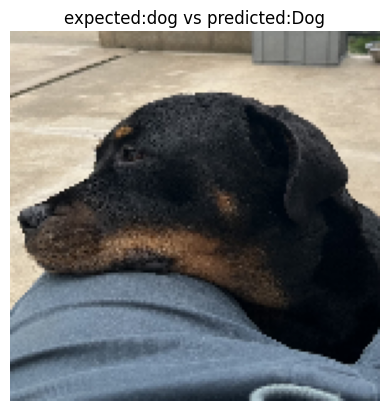

In [58]:
#testing model prediction with my dog's picture
import cv2
img_t=cv2.imread("mine.jpg",cv2.IMREAD_COLOR)
img_t=cv2.cvtColor(img_t,cv2.COLOR_BGR2RGB)
img_t=img=cv2.resize(img_t,(150,150))
def get_key(dic,item):
    item=int(item)
    for key,value in dic.items():
        if value==item:
            return key
    return None

dic={"Cat":0,"Dog":1}        

plt.imshow(img_t)

label_pre=model2.predict(img_t.reshape((1,)+img_t.shape))

plt.title("expected:dog vs predicted:{}".
          format(get_key(dic,label_pre[0][0])))
plt.axis("off")
plt.show()

comparing both models the one with light feature 
extraction and the other one with full feature extraction and data augmentation 
both end up with  a test accuracy of 90% a huge improvement, although both end up with similar accuracy, the difference when training is notable one beign super slow

In [61]:
#save both model
model.save("CatsvsDogs_light_feature_extraction_VGG16.h5")
model2.save("CatsvsDogs_feature_extraction_VGG16.h5")